# Named entity recognition

In [ ]:
import json
import os
import requests
import time
import xml.etree.ElementTree as ET

from collections import Counter

import matplotlib.pyplot as plt
import nltk

nltk.download('punkt')  # for tokenizers

### Task 4

In [2]:
bills_dir = "../bills/"
bills_files = os.listdir(bills_dir)
bills_files.sort(key=lambda f: os.path.getsize(bills_dir + f), reverse=True)

top_50_bills = bills_files[:50]

### Task 5
First splitting sentences, then lemmatising found expressions.  
I am looking for named entities WITHOUT interpunction in them, I treat names with commas as separate entities.  
(in my opinion enumerated names should appear more often than names with actual commas in them)

In [3]:
def get_lemma(expr):
    res = requests.post('http://localhost:9200', data=expr.encode('UTF-8')).text
    lemmas = []
    for line in res.splitlines():
        split = line.split()
        if len(split) == 3:
            lemmas.append(split[0].lower())  # lowercasing manually
    return " ".join(lemmas)

In [4]:
entities = Counter()

for bill in top_50_bills:
    with open(bills_dir + bill, encoding='utf-8') as file:
        sentences = nltk.tokenize.sent_tokenize(file.read(), language='polish')
        for sent in sentences:
            words = nltk.tokenize.word_tokenize(sent, language='polish')
            raw_expression = []
            for word in words[1:]:  # with used tokenizer each sentence should end with a full stop
                # isalpha to remove abbreviations which were not split
                #  e.g. very often: "Dz.U." -> ["Dz.U", "."] -> "dziennik . u" (Dz.U. is an unknown abbreviation here and weird things happen)
                if word[0].isupper() and word.isalpha():
                    raw_expression.append(word)
                elif raw_expression:
                    entities[get_lemma(" ".join(raw_expression))] += 1
                    raw_expression = []
                else:
                    raw_expression = []

### Task 6

In [7]:
for ent, count in entities.most_common(50):
    print(ent, "-", count)

numer - 7578
minister - 1273
rzeczpospolita polski - 725
kodeks - 524
policja - 460
przepis - 424
skarb państwo - 395
organ - 354
prawo - 352
kasa chory - 299
unia europejski - 294
straż graniczny - 286
minister obrona narodowy - 284
rada minister - 280
minister sprawiedliwość - 277
państwowy komisja wyborczy - 268
państwowy straż pożarny - 241
minister finanse - 239
zakład - 230
fundusz - 200
rada - 192
prezes urząd - 181
azot - 180
art - 176
zmiana - 173
urząd patentowy - 173
rozdział - 149
urząd ochrona państwo - 141
tkanina - 141
pozostały - 140
prezes rada minister - 134
i - 131
nawóz - 118
ii - 117
efta - 114
komisja - 109
biuro - 109
inspektor nadzór wewnętrzny - 109
administracja - 107
europejski porozumienie - 105
wolny handel - 105
europejski obszar gospodarczy - 103
zamawiać - 103
minister sprawa wewnętrzny - 101
sąd wysoki - 98
urząd - 97
sejm - 95
ordynacja - 94
siła zbrojny - 94
maszyna - 94


### Task 7

In [9]:
base_url = 'http://ws.clarin-pl.eu/nlprest2/base'
lpmn='any2txt|wcrft2|liner2({"model":"n82"})'

# start tasks
tasks = []
for bill_filename in top_50_bills:
    with open(bills_dir + bill_filename, encoding='utf-8') as file:
        text = file.read()
    tasks.append(requests.post(url="http://ws.clarin-pl.eu/nlprest2/base/startTask", json={"text": text, "lpmn": lpmn, "user": 'user1'}).text)

In [16]:
# check for completion and download result
for task in tasks:
    
    while True:
        response = json.loads(requests.get(base_url + "/getStatus/" + task).text)
        if response['status'] in ["QUEUE", "PROCESSING"]:
            time.sleep(5)
        elif response['status'] == "DONE":
            file_id = response["value"][0]["fileID"]
            response = requests.get(url=base_url + "/download" + file_id)
            with open("ccl/" + task, 'w', encoding="utf-8") as file:
                file.write(response.content.decode("utf-8"))
            print("Loaded:", task)
            break
        else:
            print("FAIL -", task)
            break

Loaded: e940cf7f-38e8-4771-8682-689eaa122a35
Loaded: 89efbbd5-86bf-4a09-91ae-f6f95c4e0cb1
Loaded: 844d64d6-c326-42b2-905b-48e986ce4df8
Loaded: 808242c9-3133-4efb-8def-88c369d315d4
Loaded: 49528cf5-ad94-47c8-8312-81e8c9312b9e
Loaded: e25195a4-82bf-44c5-ae2b-300389233c7a
Loaded: a09b373a-5757-4bcc-a2fc-ae422de49008
Loaded: 68560e37-5b43-49f6-9c8e-e5bd37e569f7
Loaded: a7453b3b-cfc7-4050-b890-4957b1a57c3e
Loaded: c1b2383c-c065-4e6b-8d51-95eec0af054e
Loaded: ae39e61b-9535-4f0b-a605-aa67327e45f2
Loaded: 40f67c33-578b-4dc1-8499-3c1470b81bc9
Loaded: 55576c88-c1eb-44d4-a887-c6c685a4a942
Loaded: 972370db-cc9d-4fe5-8b02-8fe83a8ef7fb
Loaded: 1322135d-a6be-48b4-b887-6ed389e96bd5
Loaded: b1071045-7d91-4c08-970b-7e6ef92f38d6
Loaded: 0f21f99e-c8da-4791-be1c-6cf1f6f0ae2a
Loaded: 56382587-8995-49e5-ba10-08de3b660e71
Loaded: 77ded88b-72c8-4c4f-9b58-6cde06aa0ffd
Loaded: 2014d9c5-9981-4397-a7dc-2e2ed32aaf2d
Loaded: 3f86e136-27dc-413c-ad75-35c44cf17b80
Loaded: aad76153-2dcc-427c-8489-c0de57451c46
Loaded: 14

### Task 8

Based on examples from tutorial: https://github.com/CLARIN-PL/NlpRest2-Tutorials

In [118]:
class Token:
    
    def __init__(self, orth, base, ctag):
        self.orth = orth
        self.base = base
        self.ctag = ctag
        
    def get_orth(self):
        return self.orth
        

class Annotation:
    
    def __init__(self, category, tokens):
        self.category = category
        self.tokens = tokens
        self.lemma = self.get_orth()
        
    def get_category(self):
        return self.category
    
    def get_orth(self):
        return " ".join([token.get_orth() for token in self.tokens])
    
    def get_lemma(self):
        return self.lemma
    

def sentence_ner(sentence):
    channels = {}
    for token in sentence.iter("tok"):
        orth = token.find("./orth").text
        base = token.find("./lex/base").text
        ctag = token.find("./lex/ctag").text
        t = Token(orth, base, ctag)
        for channel in token.iter("ann"):            
            index = int(channel.text)
            chan = channel.attrib["chan"]            
            if index > 0:                
                channels.setdefault(chan, {}).setdefault(index, []).append(t)
                
    annotations = []
    for (ann_type, group) in channels.items():
        for tokens in group.values():            
            an = Annotation(ann_type, tokens)
            annotations.append(an)
    
    return annotations


def ccl_ner(file):
    tree = ET.parse(file)
    annotations = []
    for sentence in tree.iter("sentence"):
        annotations += sentence_ner(sentence)
    return annotations

In [119]:
course_grained_freq = Counter()
course_grained_entity_freq = {}  # for Task 9
fine_grained_entity_freq = Counter()  # for Task 10

for task in tasks:
    annotations = ccl_ner("ccl/" + task)
    for annotation in annotations:
        category = annotation.get_category()
        entity = annotation.get_lemma()
        course_category = "_".join(category.split("_")[:2])
        course_grained_freq[course_category] += 1
        course_grained_entity_freq.setdefault(course_category, Counter())[entity] += 1
        fine_grained_entity_freq[(entity, category)] += 1

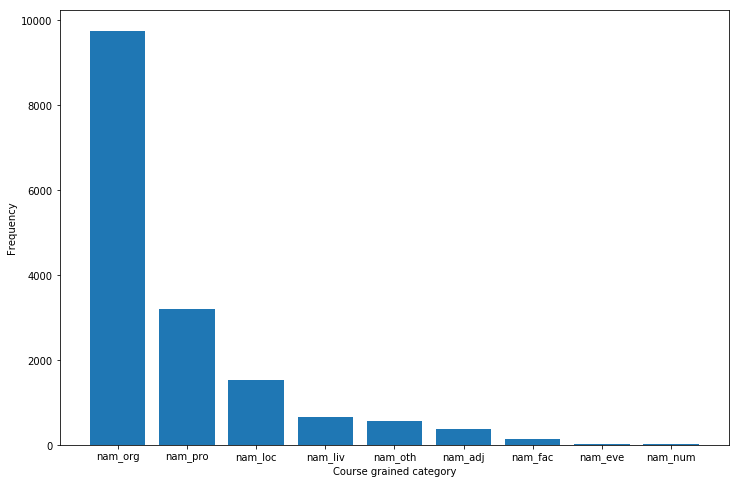

In [120]:
plt.figure(figsize=(12, 8))
sorted_course_grained_freq = {k: v for k, v in sorted(course_grained_freq.items(), key=lambda item: item[1], reverse=True)}
plt.bar(list(sorted_course_grained_freq.keys()), sorted_course_grained_freq.values())
plt.xlabel("Course grained category")
plt.ylabel("Frequency")
plt.show()

### Task 9

In [121]:
for course_category, entity_freq in course_grained_entity_freq.items():
    print("\n{}:".format(course_category))
    sorted_entity_freq = {k: v for k, v in sorted(entity_freq.items(), key=lambda kv: kv[1], reverse=True)}
    for entity, count in list(sorted_entity_freq.items())[:10]:
        print("\t{} - {}".format(entity, count))


nam_pro:
	Dz . U . - 1534
	Dz . Urz - 80
	Ordynacja podatkowa - 71
	Kodeksu karnego - 64
	Monitor Polski - 62
	Spraw Wewnętrznych - 51
	Kodeksu postępowania administracyjnego - 35
	Kodeksu postępowania karnego - 33
	Kodeksu postępowania cywilnego - 32
	Natura 2000 - 26

nam_org:
	Skarbu Państwa - 295
	Unii Europejskiej - 291
	Rada Ministrów - 261
	Państwowej Straży Pożarnej - 239
	Minister Sprawiedliwości - 233
	Prezes Rady Ministrów - 213
	Minister Obrony Narodowej - 162
	Minister Finansów - 152
	Urzędu Ochrony Państwa - 137
	EFTA - 114

nam_loc:
	Rzeczypospolitej Polskiej - 812
	Rzeczpospolita Polska - 52
	Polsce - 51
	Rzeczpospolitą Polską - 39
	Warszawie - 32
	Warszawy - 20
	Nawóz - 19
	Warszawa - 16
	Konfederacji Szwajcarskiej - 11
	Polską - 10

nam_liv:
	Kasa Chorych - 51
	Straży Granicznej - 36
	Sił Zbrojnych - 24
	Kasy Chorych - 21
	Art - 18
	Pana - 18
	Gospodarki Żywnościowej - 16
	Krajowego Depozytu - 15
	Pan - 15
	Kas Chorych - 13

nam_eve:
	EURO - 5
	Monitorze Sądowym - 2


### Task 10

In [122]:
sorted_fine_grained_entity_freq = {k: v for k, v in sorted(fine_grained_entity_freq.items(), key=lambda kv: kv[1], reverse=True)}
for (entity, category), count in list(sorted_fine_grained_entity_freq.items())[:50]:
    print("{} - {} - {}".format(entity, category, count))

Dz . U . - nam_pro_media_periodic - 1534
Rzeczypospolitej Polskiej - nam_loc_gpe_country - 812
Skarbu Państwa - nam_org_institution - 295
zł - nam_oth_currency - 293
Unii Europejskiej - nam_org_organization - 290
Rada Ministrów - nam_org_institution - 261
Minister Sprawiedliwości - nam_org_institution - 233
Prezes Rady Ministrów - nam_org_institution - 213
Państwowej Straży Pożarnej - nam_org_organization - 205
Minister Obrony Narodowej - nam_org_institution - 162
Minister Finansów - nam_org_institution - 152
Urzędu Ochrony Państwa - nam_org_institution - 137
polski - nam_adj_country - 116
EFTA - nam_org_organization - 114
Państwowa Komisja Wyborcza - nam_org_institution - 110
Urząd Patentowy - nam_org_institution - 104
Europejskiego Porozumienia o Wolnym Handlu - nam_org_company - 103
Skarb Państwa - nam_org_institution - 98
Państwowej Komisji Wyborczej - nam_org_institution - 98
euro - nam_oth_currency - 89
Prezes Urzędu - nam_org_institution - 88
OKRĘG - nam_org_organization - 81
Ok

### Task 11
#### Which of the method (counting expressions with capital letters vs. NER) worked better for the task concerned with identification of the proper names?
NER gave much more reasonable results. In the top fifty entities only a few stood out as invalid, whereas capital letters method returned many common nouns (maybe they were split by conjunctions?).
#### What are the drawbacks of the method based on capital letters?
- If proper name contains conjunctions, which are often (if not always) written in lowercase, this method would split it into multiple entities (e.g. "Minister Zdrowia i Opieki Społecznej" from NER results)  
- Anything capitalised would be caught here (e.g. `numer`, `azot`, `tkanina` in these texts, roman numerals)
- Either we assume that proper names cannot have commas or other interpunction in them (which is not true) and split entities on such symbols, or we allow/ignore them which also may yield incorrect results (e.g. in somethin like "na terenie Polski, Szwecji, ..." we would get one big named entity)
#### What are the drawbacks of the method based on NER?
- Doesn't have any context of sentences (a result of this was that many words had different base form than expected)
- Slower than the first one
#### Which of the coarse-grained NER groups has the best and which has the worst results? Try to justify this observation.
We cannot tell anything about recall of this method just by looking at these results but we can see which of the groups had some incorrect/weird results.  
- the best: `nam_org` and `nam_adj` - here all ten entities look correct, but they also look like the easiest of all groups
- the worst: `nam_liv` - 'Pan'/'Pana' is just a title (I don't know if it under "named entity"), but "Gospodarki Żywnościowej" or "Art" surely is not about living things
- there is also `nam_num` which is nearly empty so it's hard to tell what SHOULD happen here and `nam_eve`where there were only single occurences of entities
#### Do you think NER is sufficient for identifying different occurrences of the same entity (i.e. consider "USA" and "Stany Zjednoczone" and "Stany Zjednoczone Ameryki Północnej") ? If not, can you suggest an algorithm or a tool that would be able to group such names together?
NER does not have any knowledge of synonyms so it won't work for this problem. Anything that has some synonym/abbreviation data could be of use here (e.g. Wordnet from exercise 6).
#### Can you think of a real world problem that would benefit the most from application of Named Entity Recognition algorithm?
Suggesting relevant articles to read (both in something like Wikipedia and for more scientific texts).